##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Install, Import, Load Model

In [0]:
# Imports

import numpy as np
import tensorflow as tf

from lucid.modelzoo import vision_models
from lucid.misc.io import show, load, save
from lucid.misc.tfutil import create_session

import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import pickle
from lucid.optvis.objectives import wrap_objective
from collections import OrderedDict

Choose a model

In [0]:
model = vision_models.InceptionV1()
model.load_graphdef()

You can use this to see if you're running on a machine with a correctly configured GPU:

In [4]:
tf.test.is_gpu_available()

True

## Load image

First, let's take a look at the two images we want to transfer styles between. This code should feel familiar from the Lucid tutorial:

Later in the notebook there'll be an opportunity to upload your own images, too.

In [0]:
def load_img(path_to_img, max_dim=512):
  from PIL import Image
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = np.asarray(img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), 
                   Image.ANTIALIAS))
  img_max = np.iinfo(img.dtype).max
  npimg = np.divide(img, img_max, dtype=np.float32)
  return npimg


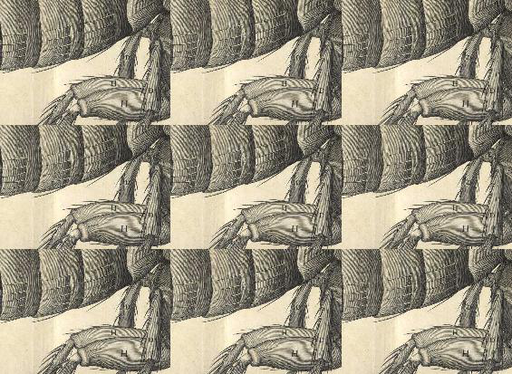

In [38]:
from os.path import basename

img_path = 'hooke-tile-random-3x3.jpg'
img_name = basename(img_path).split('.')[0]

style_image = load_img(img_path)
show(style_image)

## Set parameters

In [39]:
# This code will be different depending on how the layers are named in each model
layer_names = [x.name for x in model.layers]
layer_names

['conv2d0',
 'conv2d1',
 'conv2d2',
 'mixed3a',
 'mixed3b',
 'mixed4a',
 'mixed4b',
 'mixed4c',
 'mixed4d',
 'mixed4e',
 'mixed5a',
 'mixed5b',
 'head0_bottleneck',
 'nn0',
 'softmax0',
 'head1_bottleneck',
 'nn1',
 'softmax1',
 'softmax2']

In [0]:

style_layers = [
'conv2d0',
 'conv2d1',
 'conv2d2',
 'mixed3a',
 'mixed3b',
 'mixed4a',
 'mixed4b',
 'mixed4c',
 'mixed4d',
 'mixed4e',
 'mixed5a',
 'mixed5b']
# these constants help remember which image is at which batch dimension
TRANSFER_INDEX = 0
STYLE_INDEX = 1

## Helper functions

In [0]:
def style_transfer_param(style_image, decorrelate=True, fft=True):
  style_transfer_input = param.image(*style_image.shape[:2], decorrelate=decorrelate, fft=fft)[0]
  style_input = style_image
  return tf.stack([style_transfer_input, style_input])



In [0]:
def mean_L1(a, b):
  return tf.reduce_mean(tf.abs(a-b))

In [0]:
@wrap_objective
def activation_difference(layer_names, activation_loss_f=mean_L1, transform_f=None, difference_to=STYLE_INDEX):
  def inner(T):
    # first we collect the (constant) activations of image we're computing the difference to
    image_activations = [T(layer_name)[difference_to] for layer_name in layer_names]
    if transform_f is not None:
      image_activations = [transform_f(act) for act in image_activations]
    
    # we also set get the activations of the optimized image which will change during optimization
    optimization_activations = [T(layer)[TRANSFER_INDEX] for layer in layer_names]
    if transform_f is not None:
      optimization_activations = [transform_f(act) for act in optimization_activations]
    
    # we use the supplied loss function to compute the actual losses
    losses = [activation_loss_f(a, b) for a, b in zip(image_activations, optimization_activations)]
    return tf.add_n(losses) 
    
  return inner

In [0]:
def gram_matrix(array, normalize_magnitue=True):
  channels = tf.shape(array)[-1]
  array_flat = tf.reshape(array, [-1, channels])
  gram_matrix = tf.matmul(array_flat, array_flat, transpose_a=True)
  if normalize_magnitue:
    length = tf.shape(array_flat)[0]
    gram_matrix /= tf.cast(length, tf.float32)
  return gram_matrix

## Run fingerprint loop

In [45]:
fingerprint = OrderedDict()
fingerprint[img_name] = style_image

for layer in style_layers:
    print('Running layer: ', layer)
    param_f = lambda: style_transfer_param(style_image)

    style_obj = activation_difference([layer], transform_f=gram_matrix, difference_to=STYLE_INDEX)
    style_obj.description = "Style Loss"

    objective = - style_obj

    vis = render.render_vis(model, objective, param_f=param_f, thresholds=[1024], verbose=True, 
                            print_objectives=[style_obj])[-1]
    fingerprint[layer] = vis
    

Output hidden; open in https://colab.research.google.com to view.

## Save fingerprint

In [0]:
with open('{0}-{1}-style.pickle'.format(img_name, model.name), 'wb') as f:
    pickle.dump(fingerprint, f)

In [0]:
model.name

'InceptionV1'